<a href="https://colab.research.google.com/github/rgilyard/preprocessing-techniques/blob/main/medical_note_naive_bayes_preprocessing_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Effect or Preprocessing Techniques on a Naive Bayes Classification Model for Medical Notes

## 0. Load the data

In [1]:
# Import libraries
from google.colab import drive
import os
import pandas as pd

# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Function to load text data into train and test dataframes
def load_dataframe(csv_file, headers=False):
  # Set folder path
  folder_path = '/content/drive/My Drive/New COMP 541 Group Project/medical_note_data_master/'
  # Make a dataframe from the csv file
  if headers:
    df = pd.read_csv(folder_path + csv_file)
  else:
    df = pd.read_csv(folder_path + csv_file, header=None)
  # Set column names
  df.columns = ['file_name', 'label']

  # Set new folder path
  folder_path = '/content/drive/My Drive/New COMP 541 Group Project/medical_note_data_master/medical_notes/'
  # Add text column to dataframe
  df['text'] = None
  # Iterate over the rows of the DataFrame
  for index, row in df.iterrows():
    # This is just so I can see it working because I'm impatient
    print('.', end='')
    # Get the file name
    file_name = row['file_name']
    # Get the associated text file and add that to the text column
    with open(os.path.join(folder_path, file_name), 'r', encoding='cp1252') as file:
          content = file.read()
          df.loc[index, 'text'] = content

  return df

In [3]:
# Load data set
df = load_dataframe('completeLabels.csv')
df.head()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,file_name,label,text
0,1001.txt,Neurology,\n\n\n\n\n<B>CC:</B> Difficulty with word find...
1,1002.txt,Orthopedic,\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B> Gang...
2,1003.txt,Orthopedic,\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B> Cerv...
3,1004.txt,Radiology,\n\n\n\n\n<B>EXAM:</B>MRI LEFT SHOULDER\n\n<B>...
4,1005.txt,Orthopedic,\n\n\n\n\n<B>HISTORY OF PRESENT ILLNESS: </B> ...


## 1. Apply Common Preprocessing Steps
Sanitize the data by removing special characters and punctuation.
Tokenize the data.

In [4]:
import re
import string

In [5]:
# Function to remove contractions
def decontractions(phrase):
  phrase = re.sub(r'won\'t', 'will not', phrase)
  phrase = re.sub(r'can\'t', 'cannot', phrase)  
  phrase = re.sub(r'\'t', ' not', phrase)
  phrase = re.sub(r'n\'t', ' not', phrase)
  phrase = re.sub(r'\'re', ' are', phrase)
  phrase = re.sub(r'\'s', ' is', phrase)
  phrase = re.sub(r'\'d', ' would', phrase)
  phrase = re.sub(r'\'ll', ' will', phrase)
  phrase = re.sub(r'\'t', ' not', phrase)
  phrase = re.sub(r'\'ve', ' have', phrase)
  phrase = re.sub(r'\'m', ' am', phrase)
  return phrase

In [6]:
punctuation_pattern = f'[{re.escape(string.punctuation)}]'

# Not sure if we should remove single letter words. I don't think we'll
# I and a. Other single letter words are created by the sanitization like
# y and o (from 28y/o for example).

# Function to sanitize text
def sanitize_text(text):
  # Remove whitespace characters
  text = re.sub(r'[\n\t\r]', ' ', text)
  # Convert text to lower case
  text = text.lower()
  # Remove contractions
  text = decontractions(text)
  # Remove special characters (These might not be cp1252, might delete them)
  text = re.sub('\u200b', ' ', text)
  text = re.sub('\xa0', ' ', text)
  text = re.sub('-', ' ', text)
  # Remove html tags
  text = re.sub(r'<[^>]+>', '', text)
  # Remove strings of numbers (I'm not too sure about this one)
  text = re.sub(r'\d+', '', text)
  # Remove all other special characters
  text = re.sub(punctuation_pattern, ' ', text)
  return text


In [7]:
# Function to tokenize text
# I'm sure I can do this in one line. I'll change it later
# def tokenize(text):
#   return text.split()
def tokenize(text):
  return [word for word in text.split() if len(word) > 1]


In [8]:
# Sanitize and tokenize training set
df['sanitized'] = df['text'].apply(sanitize_text)
df['tokens'] = df['sanitized'].apply(tokenize)
# drop file_name column
df = df.drop('file_name', axis=1)
df.head()

,label,text,sanitized,tokens
0,Neurology,\n\n\n\n\n<B>CC:</B> Difficulty with word find...,cc difficulty with word finding hx th...,"[cc, difficulty, with, word, finding, hx, this..."
1,Orthopedic,\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B> Gang...,preoperative diagnosis ganglion of the ...,"[preoperative, diagnosis, ganglion, of, the, l..."
2,Orthopedic,\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B> Cerv...,preoperative diagnosis cervical myelopa...,"[preoperative, diagnosis, cervical, myelopathy..."
3,Radiology,\n\n\n\n\n<B>EXAM:</B>MRI LEFT SHOULDER\n\n<B>...,exam mri left shoulder clinical this is ...,"[exam, mri, left, shoulder, clinical, this, is..."
4,Orthopedic,\n\n\n\n\n<B>HISTORY OF PRESENT ILLNESS: </B> ...,history of present illness the patient ...,"[history, of, present, illness, the, patient, ..."


## 2. Apply Preprocessing Variations
Where we assign the techniques to models and apply them.

### Preprocessing Functions

#### Stop-word removal functions

In [9]:
# Basic stop-word removal function
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get stop words
sw_nltk = stopwords.words('english')
# print(sw_nltk)

# Remove basic stop wrods
def basic_stopword_removal(word_list):
  filtered_word_list = [word for word in word_list if word not in sw_nltk]
  return filtered_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Frequency based stop word removal function
# Get stop-word removal list based on corpus frequency
from collections import Counter

# First hyperparameter, kind of.
# Frequency threshold
threshold = 50

# Calculate the frequency of words in the entire corpus
word_freq = Counter()
for tokens in df['tokens']:
    word_freq.update(tokens)

# Create a stop-word removal list based on the frequency threshold
stop_word_list = [word for word, freq in word_freq.items() if freq >= threshold]

# Frequency-based stop-word removal function
def frequent_stopword_removal(word_list):
  filtered_word_list = [word for word in word_list if word not in sw_nltk]
  return filtered_word_list

# print(word_freq)

1246


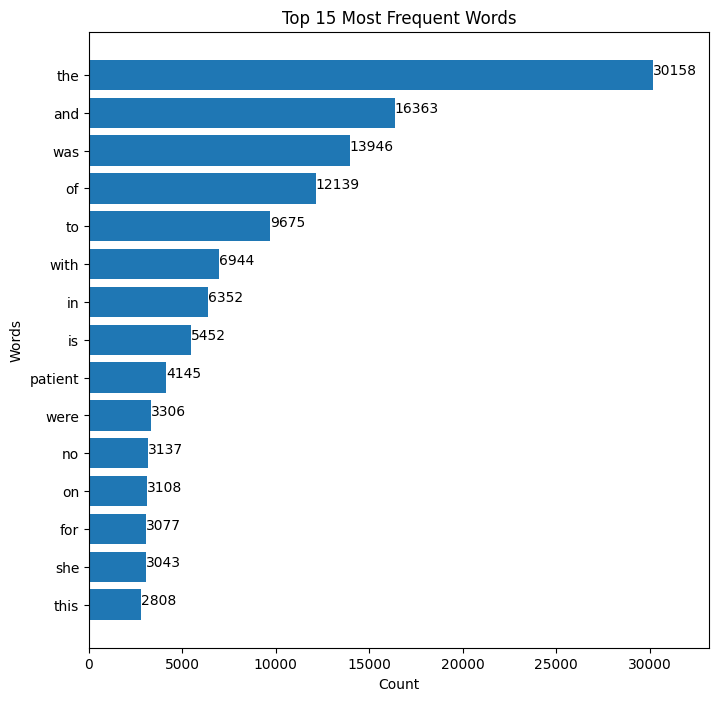

In [11]:
import matplotlib.pyplot as plt

print(len(stop_word_list))

# Make figure showing the 15 most common words
# Get the 15 most common words and their counts
most_common = word_freq.most_common(15)

words, counts = zip(*most_common)  # unzip the list of tuples
words = list(words)
counts = list(counts)

# Create horizontal bar chart
plt.figure(figsize=[8,8])
plt.barh(words, counts)

# Annotate counts on the bars
for index, count in enumerate(counts):
    plt.text(count, index, str(count))

# Invert the y-axis so the word with the highest count is at the top
plt.gca().invert_yaxis()

# Increase x-axis limit for padding so the counts don't overlap the border
plt.xlim(0, max(counts)*1.1)  # increase the x-axis limit to 110% of the maximum count

plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 15 Most Frequent Words')
plt.show()

#### Stemming Functions

In [12]:
# Lancaster stemming function
from nltk.stem import LancasterStemmer

# Initialize Lancaster stemmer
lancaster_stemmer = LancasterStemmer()

def lancaster_stem(word_list):
  stemmed_words = [lancaster_stemmer.stem(word) for word in word_list]
  return stemmed_words

In [13]:
# Porter stemming function
from nltk.stem import PorterStemmer

# Initialize the Snowball stemmer
porter_stemmer = PorterStemmer()

def porter_stem(word_list):
  stemmed_words = [porter_stemmer.stem(word) for word in word_list]
  return stemmed_words

In [14]:
# Snowball stemming function
from nltk.stem import SnowballStemmer

# Initialize the Snowball stemmer
snowball_stemmer = SnowballStemmer("english")

def snowbal_stem(word_list):
  stemmed_words = [snowball_stemmer.stem(word) for word in word_list]
  return stemmed_words

In [15]:
# Lemmatization function
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Instantiate the WordNet lemmatizer
wnl = WordNetLemmatizer()

def lemmatize(word_list):
    lemmatized_words = [wnl.lemmatize(word) for word in word_list]
    return lemmatized_words

[nltk_data] Downloading package wordnet to /root/nltk_data...


### Apply set of techniques
For training and test sets

In [16]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

# Separate the target data
X_data = df.drop(['label'], axis=1)
y_data = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [17]:
# Make a dataset for each preprocessing combination
import copy

# Dict of stop-word removal functions
stop_word_functions = {'basic': basic_stopword_removal, 'frequency': frequent_stopword_removal}
stemming_functions = {'lancaster': lancaster_stem, 'porter': porter_stem, \
                      'snowball': snowbal_stem, 'lemmatize': lemmatize}

# Preprocessed datasets
preprocessed_train = {}
preprocessed_test = {}

# Add unprocessed set
preprocessed_train['unprocessed'] = copy.deepcopy(X_train)
preprocessed_test['unprocessed'] = copy.deepcopy(X_test)

# Iterate over stop-word and stemming functions
for stop_func_name, stop_func in stop_word_functions.items():
  for stem_func_name, stem_func in stemming_functions.items():
    print(stop_func_name, stem_func_name)
    # Create a copy of the original training and test sets
    new_train_set = copy.deepcopy(X_train)
    new_test_set = copy.deepcopy(X_test)

    # Apply the stop-word removal function
    new_train_set['tokens'] = new_train_set['tokens'].apply(stop_func)
    new_test_set['tokens'] = new_test_set['tokens'].apply(stop_func)

    # Apply the stemming function
    new_train_set['tokens'] = new_train_set['tokens'].apply(stem_func)
    new_test_set['tokens'] = new_test_set['tokens'].apply(stem_func)

    # Combine the names of the stop-word and stemming functions
    dataset_name = f"{stop_func_name}_{stem_func_name}"

    # Add the processed dataset to the preprocessed_datasets dictionary
    preprocessed_train[dataset_name] = new_train_set
    preprocessed_test[dataset_name] = new_test_set

basic lancaster
basic porter
basic snowball
basic lemmatize
frequency lancaster
frequency porter
frequency snowball
frequency lemmatize


## 2. More Common Preprocessing Steps
TF-IDF and Bag of Words.

In [18]:
# Convert tokens back into string for CountVectorization
def tokens_to_text(tokens_list):
  return ' '.join(tokens_list)

for key in preprocessed_train:
  preprocessed_train[key]['token_string'] = preprocessed_train[key]['tokens'].apply(tokens_to_text)
  preprocessed_test[key]['token_string'] = preprocessed_test[key]['tokens'].apply(tokens_to_text)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

data_storage = {}

# Create nested dictionary for all data associated with a preprocessing set
# Create tf-idf matrix for each training and test set
for key in preprocessed_train:
  # Bag of Words
  bow_vectorizer = CountVectorizer()
  bow_matrix_train = bow_vectorizer.fit_transform(preprocessed_train[key]['token_string'])
  bow_matrix_test = bow_vectorizer.transform(preprocessed_test[key]['token_string'])  # Use transform() instead of fit_transform()

  # TF-IDF
  tfidf_transformer = TfidfTransformer()
  tfidf_matrix_train = tfidf_transformer.fit_transform(bow_matrix_train)
  tfidf_matrix_test = tfidf_transformer.transform(bow_matrix_test)  # Use transform() instead of fit_transform()

  # Store the transformed datasets and matrices in a nested dictionary
  data_storage[key] = {
      'X_train': preprocessed_train[key],
      'X_test': preprocessed_test[key],
      'bow_matrix_train': bow_matrix_train,
      'bow_matrix_test': bow_matrix_test,
      'tfidf_matrix_train': tfidf_matrix_train,
      'tfidf_matrix_test': tfidf_matrix_test
  }

In [20]:
# for key in data_storage:
#   print(key)
#   print('train_set')
#   print(data_storage[key]['train_set'])
#   print('test_set')
#   print(data_storage[key]['test_set'])
#   print('tfidf_matrix_train')
#   print(data_storage[key]['tfidf_matrix_train'])
#   print(data_storage[key]['tfidf_matrix_train'].shape)
#   print('tfidf_matrix_test')
#   print(data_storage[key]['tfidf_matrix_test'])
#   print(data_storage[key]['tfidf_matrix_test'].shape)
#   print()

## 3. Build Naive Bayes Models

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

models = {}

# Build models for tfidf and bow versions
for key in data_storage:
    # Get the training data
    X_train_tfidf = data_storage[key]['tfidf_matrix_train']
    X_train_bow = data_storage[key]['bow_matrix_train']

    # Initialize and train the Multinomial Naive Bayes model for TF-IDF
    clf_tfidf = MultinomialNB()
    clf_tfidf.fit(X_train_tfidf, y_train)
    
    # Initialize and train the Multinomial Naive Bayes model for Bag of Words
    clf_bow = MultinomialNB()
    clf_bow.fit(X_train_bow, y_train)

    # Store the models in the models dictionary with new keys
    models[key + '_tfidf'] = {
        'clf': clf_tfidf,
        'X_test': data_storage[key]['tfidf_matrix_test']
    }

    models[key + '_bow'] = {
        'clf': clf_bow,
        'X_test': data_storage[key]['bow_matrix_test']
    }

## 4. Measure and Compare the Models
On various metrics such as accuracy, f1-score, AUC ROC score.
I'll have to learn how to do precision and recall.

In [22]:
# This function calculates the micro-average of the
# ROC curves after calculating the individual ROC curves for each class
def roc_micro_avg(loc_y_test, loc_y_pred):
  # Initialize the counts
  TP_count = 0
  FP_count = 0
  FN_count = 0

  # Get the number of classes
  n_classes = len(np.unique(loc_y_test))

  # Binarize the labels
  y_test_binarized = label_binarize(y_test, classes=np.unique(loc_y_test))

  # Create a dictionary that maps category strings to integer labels
  unique_categories = np.unique(loc_y_test)
  category_to_label = {category: idx for idx, category in enumerate(unique_categories)}

  # Convert the category strings to integers (should I have done this earlier?)
  y_test_int = np.array([category_to_label[cat] for cat in loc_y_test])
  y_pred_int = np.array([category_to_label[cat] for cat in loc_y_pred])

  for i in range(n_classes):
    # Calculate the confusion matrix values for the current class
    TP = np.sum((y_test_int == i) & (y_pred_int == i))
    FP = np.sum((y_test_int != i) & (y_pred_int == i))
    FN = np.sum((y_test_int == i) & (y_pred_int != i))

    # Update the counts
    TP_count += TP
    FP_count += FP
    FN_count += FN

  # Calculate the micro-average TPR and FPR
  micro_avg_tpr = TP_count / (TP_count + FN_count)
  micro_avg_fpr = FP_count / (FP_count + TP_count)

  # Compute the ROC curve
  micro_avg_fpr, micro_avg_tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())

  return micro_avg_fpr, micro_avg_tpr

In [23]:
# Make predictions and evaluate results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Dict for accuracy, precision, recall, f1,
# probabilities, false positive rates, true positive rates
evaluation_results = {}

for key in models:
  # Get the test data
  X_test = models[key]['X_test']

  # Load the trained model
  clf = models[key]['clf']

  # Make predictions
  y_pred = clf.predict(X_test)
  y_pred_proba = clf.predict_proba(X_test)  # Get the probability estimates for all classes

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')
  auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

  # Calculate the micro-average for the ROC curves
  micro_avg_fpr, micro_avg_tpr = roc_micro_avg(y_test, y_pred)

  # Store the evaluation metrics
  evaluation_results[key] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_roc,
    'probabiliy': y_pred_proba,
    'micro_avg_fpr': micro_avg_fpr,
    'micro_avg_tpr': micro_avg_tpr,
  }

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Print the results
for key, metrics in evaluation_results.items():
  print(f"Results for model {key}:")
  for metric, value in metrics.items():
    if type(value) == np.float64:
      print(f"{metric}: {value:.4f}")
  print()

Results for model unprocessed_tfidf:
accuracy: 0.6050
precision: 0.5957
recall: 0.6050
f1_score: 0.5653
auc_roc: 0.9458

Results for model unprocessed_bow:
accuracy: 0.7650
precision: 0.7896
recall: 0.7650
f1_score: 0.7709
auc_roc: 0.9150

Results for model basic_lancaster_tfidf:
accuracy: 0.7200
precision: 0.7688
recall: 0.7200
f1_score: 0.7145
auc_roc: 0.9542

Results for model basic_lancaster_bow:
accuracy: 0.7750
precision: 0.7895
recall: 0.7750
f1_score: 0.7802
auc_roc: 0.9304

Results for model basic_porter_tfidf:
accuracy: 0.7250
precision: 0.7756
recall: 0.7250
f1_score: 0.7175
auc_roc: 0.9532

Results for model basic_porter_bow:
accuracy: 0.7700
precision: 0.7829
recall: 0.7700
f1_score: 0.7747
auc_roc: 0.9301

Results for model basic_snowball_tfidf:
accuracy: 0.7250
precision: 0.7756
recall: 0.7250
f1_score: 0.7175
auc_roc: 0.9532

Results for model basic_snowball_bow:
accuracy: 0.7700
precision: 0.7853
recall: 0.7700
f1_score: 0.7754
auc_roc: 0.9305

Results for model basic_

In [25]:
# Print table of results
# Prepare a list of dictionaries
data = []
for model_name, metrics in evaluation_results.items():
    data.append({
        'Model': model_name,
        'Accuracy': metrics.get('accuracy', float('nan')),
        'Precision': metrics.get('precision', float('nan')),
        'Recall': metrics.get('recall', float('nan')),
        'F1 Score': metrics.get('f1_score', float('nan'))
    })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

                        Model  Accuracy  Precision  Recall  F1 Score
0           unprocessed_tfidf     0.605   0.595686   0.605  0.565272
1             unprocessed_bow     0.765   0.789599   0.765  0.770910
2       basic_lancaster_tfidf     0.720   0.768771   0.720  0.714459
3         basic_lancaster_bow     0.775   0.789509   0.775  0.780181
4          basic_porter_tfidf     0.725   0.775560   0.725  0.717495
5            basic_porter_bow     0.770   0.782926   0.770  0.774694
6        basic_snowball_tfidf     0.725   0.775560   0.725  0.717495
7          basic_snowball_bow     0.770   0.785315   0.770  0.775433
8       basic_lemmatize_tfidf     0.725   0.770344   0.725  0.718712
9         basic_lemmatize_bow     0.770   0.782926   0.770  0.774694
10  frequency_lancaster_tfidf     0.720   0.768771   0.720  0.714459
11    frequency_lancaster_bow     0.775   0.789509   0.775  0.780181
12     frequency_porter_tfidf     0.725   0.775560   0.725  0.717495
13       frequency_porter_bow     

<ipython-input-26-1b6195263869>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=45, ha='right')


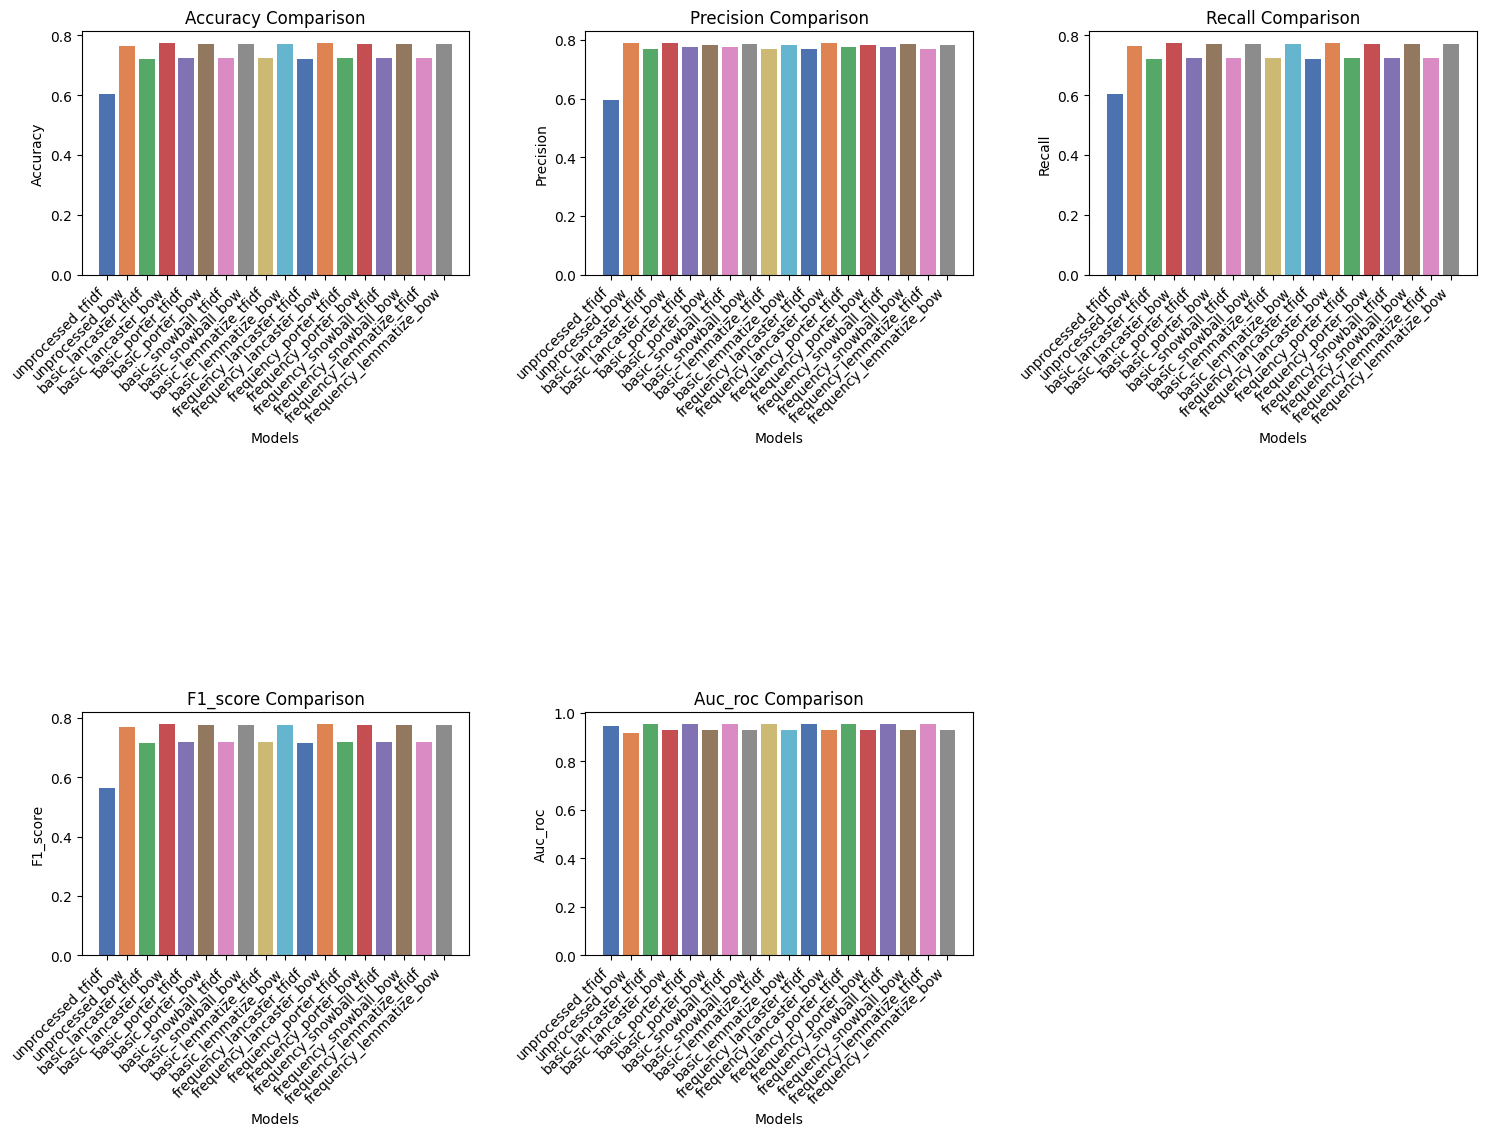

In [26]:
# Show comparisons for all metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the evaluation_results dictionary with multiple models
model_names = list(evaluation_results.keys())

# Create a list of colors for each model
colors = sns.color_palette("deep", len(model_names))

# Create a figure with a specified size
fig = plt.figure(figsize=(18, 12))

# Create subplots for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
n_metrics = len(metrics)

# Calculate the number of rows based on the number of metrics
n_rows = (n_metrics + 2) // 3

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(n_rows, 3, row * 3 + col + 1)
    
    # Get the values of the current metric for all models
    metric_values = [evaluation_results[model][metric] for model in model_names]
    
    # Create a bar plot for the current metric
    ax.bar(model_names, metric_values, color=colors)
    
    # Set the title and labels
    ax.set_title(f"{metric.capitalize()} Comparison")
    ax.set_xlabel("Models")
    ax.set_ylabel(metric.capitalize())

    # Rotate x-axis tick labels
    ax.set_xticklabels(model_names, rotation=45, ha='right')

# Adjust the layout and display the figure
# Add extra space between the subplots
plt.subplots_adjust(wspace=0.3, hspace=1.8)
plt.show()


In [27]:
import plotly.graph_objs as go
import pandas as pd

model_names = list(evaluation_results.keys())

# Convert to a DataFrame
data = []
for model in model_names:
    model_data = {"Model": model}
    model_data.update(evaluation_results[model])
    data.append(model_data)

df = pd.DataFrame(data)

# Create radar chart
fig = go.Figure()

for index, row in df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=[row[metric] for metric in metrics],
        theta=[metric.capitalize() for metric in metrics],
        fill='toself',
        name=row['Model']
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
    title="Radar Chart for Model Comparison"
)
fig.show()



<ipython-input-28-02c9ea364f99>:4: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



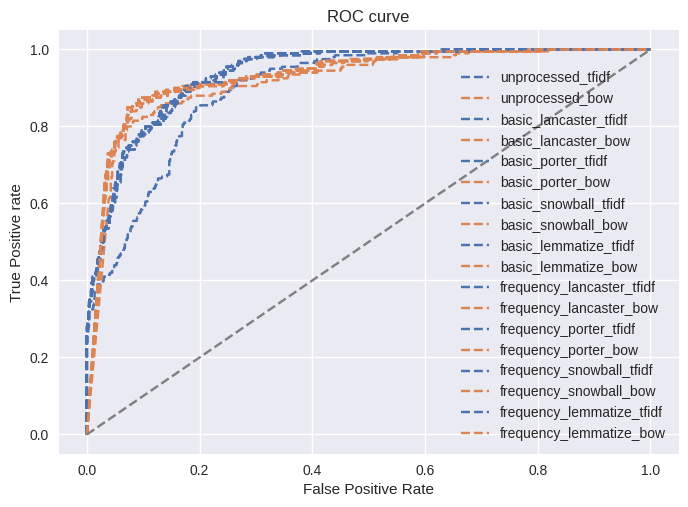

In [28]:
# Print AUC ROC graph
import matplotlib.pyplot as plt

plt.style.use('seaborn')
color_list = sns.color_palette('deep', len(model_names))

# plot roc curves for each model
for index, key in enumerate(evaluation_results):
  # Plot AUC score
  plt.plot(evaluation_results[key]['micro_avg_fpr'], evaluation_results[key]['micro_avg_tpr'], \
           linestyle='--', color=color_list[index % 2], label=key)

# Compute macro-average ROC curve and ROC area
n_classes = len(np.unique(y_test))
all_fpr = np.unique(np.concatenate([evaluation_results[key]['micro_avg_fpr'] for key in evaluation_results]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for key in evaluation_results:
    mean_tpr += np.interp(all_fpr, evaluation_results[key]['micro_avg_fpr'], evaluation_results[key]['micro_avg_tpr'])

# Average it and compute AUC
mean_tpr /= n_classes

# Now, you can plot the random guessing line as follows
plt.plot(all_fpr, all_fpr, linestyle='--', color='grey')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC', dpi=300)
plt.show();

In [29]:
# Find average difference between the accurace of BOW and TF-IDF models

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']

# Get the model names
keys = list(evaluation_results.keys())
avg_diff_list = {}
avg_bow = {}
avg_tfidf = {}
# max = {}
# min = {}

# Iterate through each metric
for metric in metrics:
  # Initialize variables to store the differences and count the pairs
  bow_sum = 0
  tfidf_sum = 0
  difference_sum = 0
  pair_count = 0
  # Iterate through the keys of the evaluation_results dictionary
  for i in range(0, len(keys), 2):
      # Check if the next key exists
      if i + 1 < len(keys):
          tfidf_key = keys[i]
          bow_key = keys[i + 1]

          # Keep track of BOW and TF-IDF
          bow_sum = bow_sum + evaluation_results[tfidf_key][metric]
          tfidf_sum = tfidf_sum + evaluation_results[bow_key][metric]

          # Calculate the accuracy difference between the BOW and TF-IDF models
          accuracy_difference = evaluation_results[bow_key][metric] - evaluation_results[tfidf_key][metric]

          # Accumulate the difference and increment the pair count
          difference_sum += accuracy_difference
          pair_count += 1

  # Calculate the averages of bow and tfidf
  avg_bow[metric] = bow_sum / pair_count
  avg_tfidf[metric] = tfidf_sum / pair_count
  # Calculate the average difference
  average_difference = difference_sum / pair_count
  avg_diff_list[metric] = average_difference

  print(f"The average difference between BOW and TF-IDF {metric} is:", average_difference)

The average difference between BOW and TF-IDF accuracy is: 0.06000000000000004
The average difference between BOW and TF-IDF precision is: 0.03275458619506382
The average difference between BOW and TF-IDF recall is: 0.06000000000000004
The average difference between BOW and TF-IDF f1_score is: 0.07548038554792458
The average difference between BOW and TF-IDF auc_roc is: -0.024379661609266953


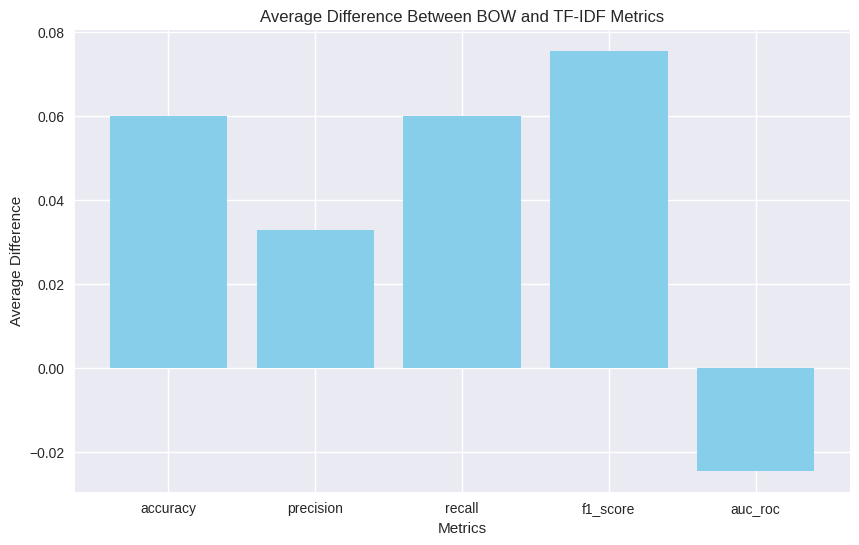

In [30]:
# Get the keys and values from the dictionary
metrics = list(avg_diff_list.keys())
avg_diff_values = list(avg_diff_list.values())

# Create a bar chart
plt.figure(figsize=(10, 6)) # Adjust the size of the plot as needed
plt.bar(metrics, avg_diff_values, color = 'skyblue') 

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Average Difference')
plt.title('Average Difference Between BOW and TF-IDF Metrics')

# Display the plot
plt.show()


In [31]:
# Assuming the evaluation_results dictionary with multiple models

greatest_differences = {}

# Iterate through each metric
for metric in metrics:
    min_value = float('inf')
    max_value = float('-inf')

    # Iterate through the values of the current metric for all models
    for model in model_names:
        value = evaluation_results[model][metric]

        # Update the min and max values
        min_value = min(min_value, value)
        max_value = max(max_value, value)

    # Calculate the greatest difference for the current metric
    greatest_difference = max_value - min_value
    greatest_differences[metric] = greatest_difference

print("Greatest differences for each metric:")
for metric, difference in greatest_differences.items():
    print(f"{metric.capitalize()}: {difference}")

Greatest differences for each metric:
Accuracy: 0.17000000000000004
Precision: 0.19391311098032937
Recall: 0.17000000000000004
F1_score: 0.21490964240677524
Auc_roc: 0.03923911061027119


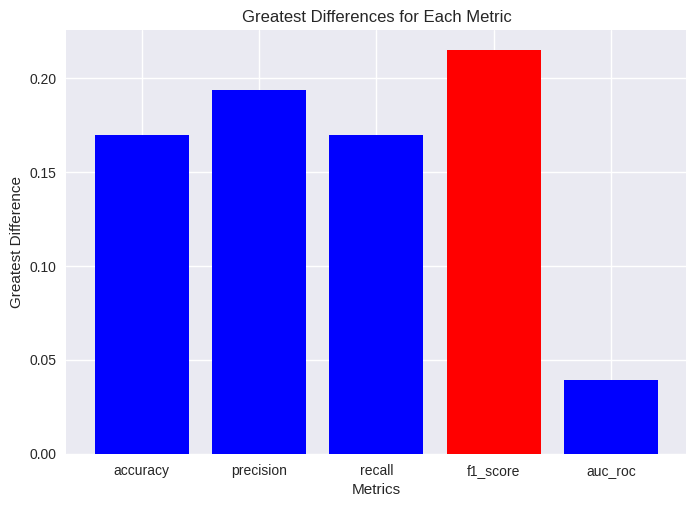

In [32]:
# Assuming your greatest_differences dictionary looks something like this

metrics = list(greatest_differences.keys())
differences = list(greatest_differences.values())

# Find the index of the maximum difference
max_diff_index = differences.index(max(differences))

# Make a color list, default color is blue
colors = ['b'] * len(differences)

# Set the color of the maximum bar to red
colors[max_diff_index] = 'r'

plt.bar(metrics, differences, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Greatest Difference')
plt.title('Greatest Differences for Each Metric')
plt.show()

## 5. Conclusions